## E2E example on GestureSet Dataset

#### Import Configuration Module

In [1]:
# pd.options.mode.chained_assignment = None  # default='warn'
import yaml

Load configuration file

In [2]:
with open("../config.yml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

#### Load Tabular-like data with more than one dimension/column

In [3]:
from crossai.loader import csv_loader

data_dir_path = config['PATH']['RAW']['GESTURE_SET'] + '/allergic_rhinitis/train'
df = csv_loader(path=data_dir_path)
df.head()

Loaded classes: ['03a', '02a']


,instance,label,feature,data
0,1,03a,acc_x_axis_g,"[1.332, 1.254, 1.128, 1.063, 0.977, 0.836, 0.6..."
1,1,03a,acc_y_axis_g,"[0.011, 0.113, 0.218, 0.291, 0.363, 0.487, 0.6..."
2,1,03a,acc_z_axis_g,"[1.007, 0.745, 0.47, 0.25, 0.037, -0.053, -0.0..."
3,1,03a,gyr_x_axis_deg/s,"[-10.553, 19.642, 38.552, 48.495, 56.913, 64.0..."
4,1,03a,gyr_y_axis_deg/s,"[-127.673, -130.54, -130.174, -118.34, -86.742..."


#### Create CrossAI Tabular Data Object to be Used for the Pipeline

In [4]:
from crossai.pipelines.tabular import Tabular

cai_tabular = Tabular(df)

In [5]:
print(cai_tabular.feature)
print(cai_tabular.labels)
print(cai_tabular.data)
print(cai_tabular.instance)

0          acc_x_axis_g
1          acc_y_axis_g
2          acc_z_axis_g
3      gyr_x_axis_deg/s
4      gyr_y_axis_deg/s
             ...       
547        acc_y_axis_g
548        acc_z_axis_g
549    gyr_x_axis_deg/s
550    gyr_y_axis_deg/s
551    gyr_z_axis_deg/s
Name: feature, Length: 552, dtype: object
0      03a
1      03a
2      03a
3      03a
4      03a
      ... 
547    02a
548    02a
549    02a
550    02a
551    02a
Name: label, Length: 552, dtype: object
0      [1.332, 1.254, 1.128, 1.063, 0.977, 0.836, 0.6...
1      [0.011, 0.113, 0.218, 0.291, 0.363, 0.487, 0.6...
2      [1.007, 0.745, 0.47, 0.25, 0.037, -0.053, -0.0...
3      [-10.553, 19.642, 38.552, 48.495, 56.913, 64.0...
4      [-127.673, -130.54, -130.174, -118.34, -86.742...
                             ...                        
547    [0.59, 0.552, 0.596, 0.725, 0.823, 0.852, 0.88...
548    [-0.033, 0.052, 0.154, 0.153, 0.102, 0.038, -0...
549    [50.691, 42.334, 37.088, 38.552, 40.809, 38.49...
550    [-13.847, 26.

In [6]:
print(cai_tabular.data.shape)
print(cai_tabular.data[0].shape)
print(cai_tabular.data[0][0].shape)
print(cai_tabular.labels.shape)

(552,)
(1512,)
()
(552,)


##### Contruct Pipeline

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from crossai.pipelines.timeseries import Transformer
from crossai.processing import encode_labels
from crossai.pipelines import TimeMeasurementWrapper
from crossai.pipelines.timeseries import PadOrTrim
from crossai.pipelines.tabular import MagnitudeExtractor, AxisToModelShape, \
    MultiAxisSlidingWindow
from crossai.pipelines.motion import PureAccExtractor
from crossai.pipelines.preparation import Scaler
from crossai.pipelines.timeseries import ToPandas

ME = TimeMeasurementWrapper(
    MagnitudeExtractor(
        [[['acc_x_axis_g','acc_y_axis_g','acc_z_axis_g'],'acc_mag'],
        [['gyr_x_axis_deg/s','gyr_y_axis_deg/s','gyr_z_axis_deg/s'],'gyr_mag']]
    )
)
PAX = TimeMeasurementWrapper(
    PureAccExtractor(
        Fs=100,
        acc_x='acc_x_axis_g',
        acc_y='acc_y_axis_g',
        acc_z='acc_z_axis_g'
    )
)
POT = PadOrTrim(fill_value=0, pad_type='mean')
MSW = MultiAxisSlidingWindow(window_size=50, step_size=25)
SS = Scaler(StandardScaler())
AXMS = AxisToModelShape()
LE = Transformer(encode_labels)
TP = ToPandas()

In [8]:
pipe = Pipeline([
    ('magex', ME),
    ('POT', POT),
    ('MSW', MSW),
    ('SS', SS),
    ('AXMS', AXMS),
    # ('LE', LE),
    # ('TP', TP)
])
pipe.fit_transform(cai_tabular)

Transformer MagnitudeExtractor took 0.00 seconds to fit.
Transformer MagnitudeExtractor took 0.10 seconds to transform.


#### Overview of CrossAI Tabular Data Object

In [9]:
print(cai_tabular.feature[:5], type(cai_tabular.feature))
print(cai_tabular.labels[:5],type(cai_tabular.labels))
print(cai_tabular.data[:5], type(cai_tabular.data))
print(cai_tabular.instance[:5], type(cai_tabular.instance))

['acc_x_axis_g', 'acc_x_axis_g', 'acc_x_axis_g', 'acc_x_axis_g', 'acc_x_axis_g'] <class 'list'>
['03a' '03a' '03a' '03a' '03a'] <class 'numpy.ndarray'>
[[[-0.17649715 -0.19173455 -0.18024594 ... -0.54718953 -0.17260015
    1.3279581 ]
  [-0.17957743 -0.1927242  -0.1854422  ... -0.7619299  -0.17716952
    1.4295673 ]
  [-0.1821363  -0.19264282 -0.18973333 ... -0.8952167  -0.18082827
    1.5215306 ]
  ...
  [-0.18803133 -0.18833739 -0.19621243 ...  0.9230919  -0.1854552
    2.1301134 ]
  [-0.18713923 -0.19044158 -0.18775034 ...  1.1336176  -0.1840271
    2.5132542 ]
  [-0.18603176 -0.19362089 -0.18108945 ...  1.0447536  -0.17881137
    2.2335916 ]]

 [[-0.18842407 -0.18327959 -0.19239202 ... -1.1417483  -0.18260156
    1.3118609 ]
  [-0.19724087 -0.18355256 -0.19780546 ... -0.676885   -0.1824368
    1.0713362 ]
  [-0.20325322 -0.1849419  -0.2026875  ... -0.12825291 -0.18010731
    0.7018813 ]
  ...
  [-0.17440008 -0.19791928 -0.18406437 ... -0.78443956 -0.1716479
    1.2152058 ]
  [-0.17

In [10]:
print(cai_tabular.data.shape)
print(cai_tabular.data[0].shape)
print(cai_tabular.data[0][0].shape)
print(cai_tabular.labels.shape)

(5060, 50, 8)
(50, 8)
(8,)
(5060,)


#### Data Preparation for training

In [11]:
# import numpy as np
# X = np.stack(cai_tabular.data.values, axis=0, dtype=np.float32)
# class_labels = cai_tabular.labels.values

In [12]:
# class_labels[:2]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cai_tabular.data,
                                                    cai_tabular.labels,
                                                    test_size=0.2,
                                                    random_state=42)

In [14]:
X_train.shape, X_test.shape

((4048, 50, 8), (1012, 50, 8))

In [15]:
y_train.shape, y_test.shape

((4048,), (1012,))

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [17]:
y_train[:2], y_test[:2]

(array([0, 1]), array([0, 0]))

#### Create AI Model through CrossAI module

In [18]:
from crossai.ai.nn1d import CNN1D

cnn1d = CNN1D(
    input_shape=X_train.shape[1:],
    include_top=True,
    num_classes=2,
    classifier_activation="softmax",
    drp=.5,
    spatial=False,
    mc_inference=None
)

cnn1d.summary()

2023-11-19 13:45:26.884448: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 13:45:28.108596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50, 8)]           0         
                                                                 
 conv1d (Conv1D)             (None, 48, 64)            1600      
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 64)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 128)           24704     
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 128)           49280     
                                                             

2023-11-19 13:45:33.104381: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [20]:
cnn1d.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history = cnn1d.fit(X_train, y_train, epochs=100,
                    validation_split=.2,
                    verbose=2,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr]
                    )

Epoch 1/100
51/51 - 4s - loss: 0.5253 - accuracy: 0.6902 - val_loss: 0.3745 - val_accuracy: 0.8728 - lr: 1.0000e-04 - 4s/epoch - 79ms/step
Epoch 2/100
51/51 - 1s - loss: 0.2738 - accuracy: 0.9002 - val_loss: 0.1576 - val_accuracy: 0.9605 - lr: 1.0000e-04 - 752ms/epoch - 15ms/step
Epoch 3/100
51/51 - 1s - loss: 0.1506 - accuracy: 0.9444 - val_loss: 0.1059 - val_accuracy: 0.9605 - lr: 1.0000e-04 - 1s/epoch - 20ms/step
Epoch 4/100
51/51 - 0s - loss: 0.1254 - accuracy: 0.9450 - val_loss: 0.0959 - val_accuracy: 0.9605 - lr: 1.0000e-04 - 496ms/epoch - 10ms/step
Epoch 5/100
51/51 - 2s - loss: 0.1167 - accuracy: 0.9450 - val_loss: 0.0919 - val_accuracy: 0.9605 - lr: 1.0000e-04 - 2s/epoch - 44ms/step
Epoch 6/100
51/51 - 0s - loss: 0.1133 - accuracy: 0.9456 - val_loss: 0.0911 - val_accuracy: 0.9605 - lr: 1.0000e-04 - 419ms/epoch - 8ms/step
Epoch 7/100
51/51 - 0s - loss: 0.1111 - accuracy: 0.9466 - val_loss: 0.0916 - val_accuracy: 0.9605 - lr: 1.0000e-04 - 475ms/epoch - 9ms/step
Epoch 8/100
51/51

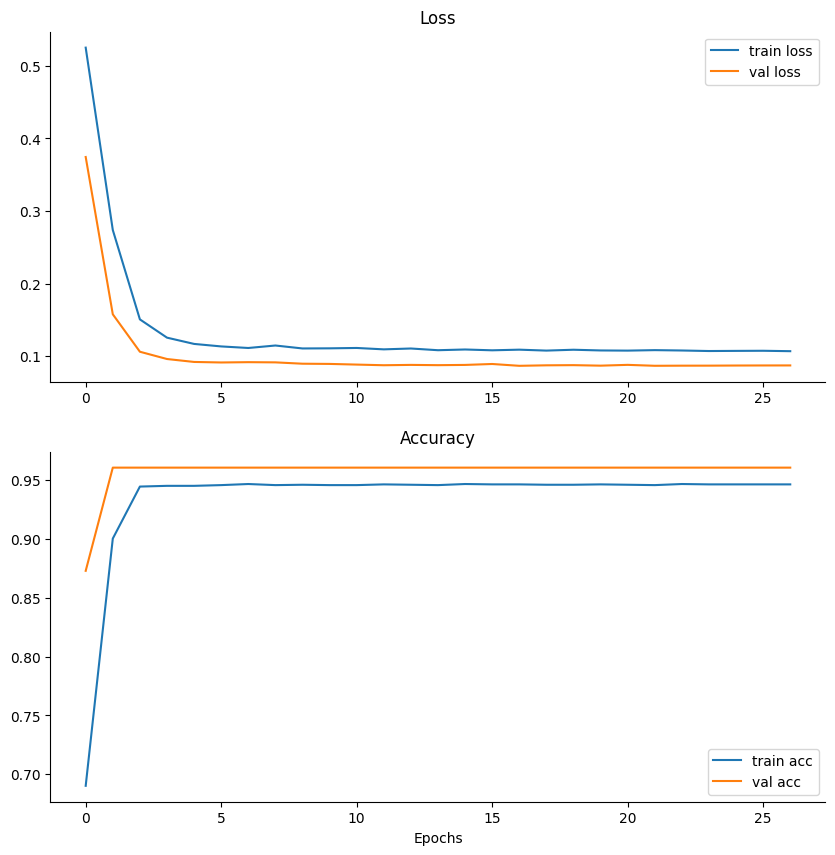

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(history.history['loss'], label='train loss')
axs[0].plot(history.history['val_loss'], label='val loss')
axs[0].legend(loc='best')
axs[0].set_title('Loss')

axs[1].plot(history.history['accuracy'], label='train acc')
axs[1].plot(history.history['val_accuracy'], label='val acc')
axs[1].legend(loc='best')
axs[1].set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

## Train a statistical model

##### Prepare data

In [23]:
# flatten timesteps * axes
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

X_test_flatten.shape, X_test_flatten.shape

((1012, 400), (1012, 400))

In [24]:
# train a random forest classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model.fit(X_train_flatten, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

#### Make predictions

In [25]:
y_pred_probs = model.predict_proba(X_test_flatten)
predictions = model.predict(X_test_flatten)

##### Plot Confusion Matrix

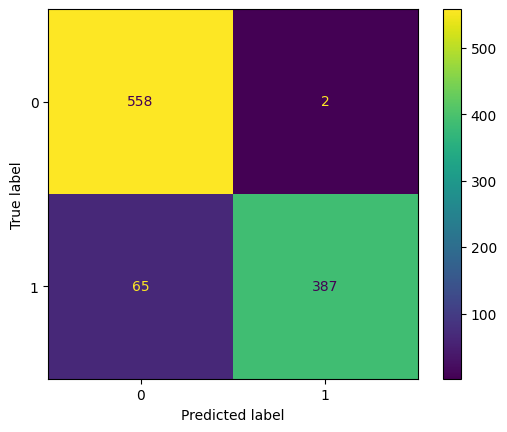

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

# Evaluation

In [27]:
print(le.classes_)

['02a' '03a']


In [28]:
# from crossai.performance.loader import csv_loader
import crossai.performance.loader as cpl

evaluation_inst_path = config['PATH']['EVALUATION']['INSTANCE']
# load evaluation object by providing the path to the folder containing the data,
# the baseline label and the label mapping
cai_evaluation = cpl.csv_loader(evaluation_inst_path, list(le.classes_))

FileNotFoundError: [Errno 2] No such file or directory: '/home/konto/datasets/gesture_set/allergic_rhinitis/evaluate/02a/02a_524_946_02a_1_0_100_AccGyr_1_1_1_0_00_61683eb7ed1368992649f25f.json'

In [ ]:
from crossai_lib.performance._utils_visualization import plot_signal
plot_signal(Evaluation_object.data[0:3], 'Raw signal',['x','y','z'], segments=[[525,946,'aquamarine']])

Perform similar processing as with train data

In [ ]:
from crossai_lib.pipelines.evaluation import addModeltoObject, pilotEvaluation
#add these 2 steps to the pipeline
#AMTO= addModeltoObject(model)
#PE = pilotEvaluation(per_window=True)

#remove LE from the pipeline
MSW_pipeline.steps.pop()

#add the steps to the pipeline
#MSW_pipeline.steps.append(('AMTO', AMTO))
#MSW_pipeline.steps.append(('PE', PE))

MSW_pipeline.transform(Evaluation_object)

In [ ]:
print(Evaluation_object.data.shape)

In [ ]:
print(Evaluation_object.instance)

Labels are being handled inside object with slidng window transformer

In [ ]:
print(Evaluation_object.labels)

In [ ]:
from crossai_lib.performance.pilot_evaluation import perform_evaluation

results = perform_evaluation(model, Evaluation_object.data, Evaluation_object.labels, repeats=1, per_window=True, GT_threshold=0.9)

In [ ]:
print(results['mean_pred'].shape)

In [ ]:
print('mean_predictions: ', results['mean_pred'])
print('STD:', results['STD'])
print('Variance:', results['variance'])
print('Entropy: ', results['entropy'])
print('Predicted Classes: ', results['predicted_classes'])

Count Insertions, deletions, substitutions and corrects

In [ ]:
print('Y_eval: ', Evaluation_object.labels)
print('Y_pred: ', results['predicted_classes'])

print('Insertions: ', results['insertions'])
print('Deletions: ', results['deletions'])
print('Substitutions: ', results['substitutions'])
print('Corrects: ', results['correct'])

In [ ]:
#get index of 0
index = np.where(Evaluation_object.labels == 0)[0]
print('Index of 0: ', index)

Plot section

In [ ]:
from crossai_lib.performance._utils_visualization import scatter_predictions
scatter_predictions(results['mean_pred'], title="Scater plotted predictions", labels=list(LE.le.classes_), save_path=None, show=True, s=50, color_threshold=0.9)

In [ ]:
from crossai_lib.performance._utils_visualization import interpolate_plot_predictions
import scipy.signal as signal

interpolate_plot_predictions(results['mean_pred'], title="Interpolated predictions", labels=list(LE.le.classes_))

b = signal.butter(5, 0.1, btype = "lowpass", analog = False, output = "sos")
interpolate_plot_predictions(results['mean_pred'], title="Filtered interpolated predictions", labels=list(LE.le.classes_), filter=b)

interpolate_plot_predictions(results['mean_pred'], title="Clipped filtered interpolated predictions", labels=list(LE.le.classes_), filter=b, clip_list=[0.7,0.7])



# Batch pilot eval demo

In [ ]:
from crossai_lib.performance.batch_pilot_evaluation import perform_batch_evaluation

perform_batch_evaluation(model,
                         config["batch_evaluation_data_path"],
                         list(LE.le.classes_),
                         pipeline=MSW_pipeline,
                         save_path=config["batch_evaluation_save_path"],
                         per_window=False,
                         repeats=2)